<a href="https://colab.research.google.com/github/Juanvr/Dathoven/blob/main/notebooks/4%20-%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model

We need a model that can process and predict the three dimensions of our data: interval, duration and relative offset.

We create dictionaries for each of the dimensions:

In [39]:
import fractions

In [40]:
duration_to_number = {}
number_to_duration  = {}

count=0
duration = 0
while duration <= 20:
    number_to_duration[count] = duration
    duration_to_number[duration] = count
    count+=1
    duration+=0.25

duration = 0
while duration <= 20:
    if not duration in duration_to_number:
        number_to_duration[count] = duration
        duration_to_number[duration] = count
        count+=1
    duration+=fractions.Fraction(1,3)

In [41]:
interval_to_number = {}
number_to_interval = {}

for i in range(0,100):
    interval_to_number[i] = i
    interval_to_number[-i] = 100 + i
    number_to_interval[i] = i
    number_to_interval[100+i] = -i

We will use the same dictionary for duration and offset.

In [42]:
train_set = [ \
    [\
        [
         duration_to_number[round(element['relative_offset']*4)/4] if (round(element['relative_offset']*4)/4 in duration_to_number) else 1, 
         interval_to_number[element['interval']], 
         duration_to_number[element['duration']]
        ] \
    for element in track]\
for track in tracks]

In [43]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = np.array(sequences)[i:end_ix, :], np.array(sequences)[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [44]:
X, y = [], []
for i in range(len(train_set)):
    X_temp, y_temp = split_sequences(train_set[i], 10)
      
    if (len(X_temp) > 0 and len(y_temp) > 0):
        X = X_temp if len(X)==0 else np.concatenate([X,X_temp])
        y = y_temp if len(y)==0 else np.concatenate([y,y_temp])
    



In [45]:
from keras.layers import Dense, Dropout, LSTM, Input
from keras import Model
from keras.metrics import SparseTopKCategoricalAccuracy

In [46]:
hid = 20
past_time_steps = 10
n_features = 3
future_time_steps = 1
categorical_accuracy_k = 5
inputs = Input(shape=(past_time_steps, n_features))
m = LSTM(hid, return_sequences=True)(inputs)
m = Dropout(0.5)(m)
m = LSTM(hid)(m)
m = Dropout(0.5)(m)

outputA = Dense(len(duration_to_number), activation='softmax')(m)
outputB = Dense(len(interval_to_number), activation='softmax')(m)
outputC = Dense(len(duration_to_number), activation='softmax')(m)

m = Model(inputs=[inputs], outputs=[outputA, outputB, outputC])

m.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=[SparseTopKCategoricalAccuracy(k=5, name='sparse_top_k_categorical_accuracy')])


m.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 3)]      0                                            
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 10, 20)       1920        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 10, 20)       0           lstm_4[0][0]                     
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 20)           3280        dropout[0][0]                    
______________________________________________________________________________________________

In [50]:
! mkdir models_checkpoints

In [51]:
# checkpoint
filepath="models_checkpoints/weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
callbacks_list = [checkpoint, early_stopping]

In [52]:
BATCH_SIZE = 64
EPOCHS = 50

In [53]:
y1 = y[:,0]
y2 = y[:,1]
y3 = y[:,2]

In [54]:
history = m.fit(X, [y1,y2,y3], validation_split = 0.1,  batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callbacks_list)

Epoch 1/50
191/191 [==============================] - 9s 19ms/step - loss: 10.8096 - dense_2_loss: 3.5514 - dense_3_loss: 4.2857 - dense_4_loss: 2.9725 - dense_2_sparse_top_k_categorical_accuracy: 0.5437 - dense_3_sparse_top_k_categorical_accuracy: 0.4049 - dense_4_sparse_top_k_categorical_accuracy: 0.7621 - val_loss: 4.2304 - val_dense_2_loss: 1.1909 - val_dense_3_loss: 2.4818 - val_dense_4_loss: 0.5576 - val_dense_2_sparse_top_k_categorical_accuracy: 0.9933 - val_dense_3_sparse_top_k_categorical_accuracy: 0.6356 - val_dense_4_sparse_top_k_categorical_accuracy: 0.9911

Epoch 00001: saving model to models_checkpoints/weights-improvement-01-4.23.hdf5
Epoch 2/50
191/191 [==============================] - 2s 13ms/step - loss: 4.2118 - dense_2_loss: 1.1809 - dense_3_loss: 2.7132 - dense_4_loss: 0.3177 - dense_2_sparse_top_k_categorical_accuracy: 0.9848 - dense_3_sparse_top_k_categorical_accuracy: 0.6034 - dense_4_sparse_top_k_categorical_accuracy: 0.9980 - val_loss: 4.0474 - val_dense_2_lo

In [55]:
from matplotlib import pyplot as plt

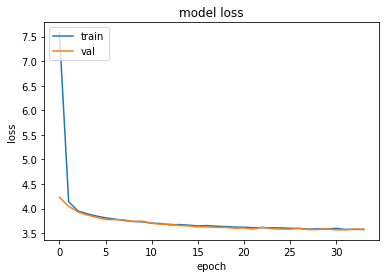

In [56]:
plt.plot(m.history.history['loss'])
plt.plot(m.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [57]:
from random import randint
def sample(preds):
    sorted_indexes = np.argsort(preds)[::-1]
    return sorted_indexes[randint(0,3)]

In [58]:
def sample_seq( seq, seq_length, model, number_to_note, output_seq_length ):
    if output_seq_length <= len(seq): raise Exception("output_seq_length must be higher than seq_length")
        
    output_seq = seq
    for i in range(output_seq_length - len(seq)):
        input_sequence = [seq[-seq_length:]]
        x = [pad_sequences(input_sequence, maxlen = seq_length, padding="pre")]
        prediction = model.predict(x)
        
        index1 = sample(prediction)
        
        index = sample(prediction[0])
        output_seq.append(index)
    #[number_to_note(number) for number in output_seq]
    return output_seq

In [59]:
from keras.preprocessing.sequence import pad_sequences

In [60]:
def pad( input_seq, desired_length, fill_value):
    if len(input_seq) >= desired_length:
        return input_seq
    else: 
        [input_seq.insert(0, fill_value) for i in range(0, desired_length - len(input_seq))]
        return input_seq

In [61]:
def sample_seq( input_seq, length_expected_by_model, model, output_seq_length, padding_fill_value ):
    if output_seq_length <= len(input_seq): raise Exception("output_seq_length must be higher than seq_length")
        
    output_seq = input_seq
    for i in range(output_seq_length - len(input_seq)):
        input_sequence = input_seq[-length_expected_by_model:]
        x = [pad(input_sequence, length_expected_by_model, padding_fill_value)]
        #print(x)
        prediction = model.predict(np.array(x))
        #print(prediction[0][0])
        
        index1 = sample(prediction[0][0])
        index2 = sample(prediction[1][0])
        index3 = sample(prediction[2][0])
        #index = sample(prediction[0])
        output_seq.append([index1, index2, index3])
    return output_seq

In [62]:
sample_seq([[1,1,1]], 10, m, 5, [0,0,0])

[[1, 1, 1], [0, 105, 24], [2, 100, 3], [3, 102, 3], [0, 100, 81]]

In [63]:
generated_vector = sample_seq([[1,1,1]], 10, m, 50, [0,0,0])

In [64]:
generated_vector

[[1, 1, 1],
 [37, 100, 16],
 [2, 102, 1],
 [0, 100, 3],
 [3, 2, 81],
 [1, 102, 1],
 [3, 2, 1],
 [3, 102, 81],
 [3, 100, 81],
 [2, 102, 2],
 [0, 105, 81],
 [3, 105, 3],
 [3, 100, 3],
 [3, 105, 1],
 [1, 105, 2],
 [2, 100, 3],
 [3, 102, 3],
 [0, 102, 3],
 [1, 2, 2],
 [2, 2, 2],
 [2, 102, 1],
 [1, 102, 3],
 [0, 100, 2],
 [2, 105, 81],
 [1, 100, 1],
 [1, 100, 2],
 [1, 100, 1],
 [0, 2, 2],
 [2, 105, 81],
 [2, 100, 2],
 [3, 102, 1],
 [3, 105, 2],
 [2, 100, 2],
 [1, 102, 81],
 [2, 105, 81],
 [3, 2, 2],
 [0, 2, 3],
 [0, 2, 81],
 [3, 102, 2],
 [3, 105, 1],
 [0, 100, 3],
 [3, 100, 3],
 [0, 105, 81],
 [2, 102, 81],
 [3, 2, 81],
 [1, 2, 1],
 [0, 102, 2],
 [1, 2, 2],
 [3, 100, 2],
 [3, 105, 1]]

In [65]:
generated_intervals = [{'relative_offset': number_to_duration[generated_item[0]], 'interval': number_to_interval[generated_item[1]], 'duration': number_to_duration[generated_item[2]]} for generated_item in generated_vector]

In [66]:
generated_intervals

[{'duration': 0.25, 'interval': 1, 'relative_offset': 0.25},
 {'duration': 4.0, 'interval': 0, 'relative_offset': 9.25},
 {'duration': 0.25, 'interval': -2, 'relative_offset': 0.5},
 {'duration': 0.75, 'interval': 0, 'relative_offset': 0},
 {'duration': Fraction(1, 3), 'interval': 2, 'relative_offset': 0.75},
 {'duration': 0.25, 'interval': -2, 'relative_offset': 0.25},
 {'duration': 0.25, 'interval': 2, 'relative_offset': 0.75},
 {'duration': Fraction(1, 3), 'interval': -2, 'relative_offset': 0.75},
 {'duration': Fraction(1, 3), 'interval': 0, 'relative_offset': 0.75},
 {'duration': 0.5, 'interval': -2, 'relative_offset': 0.5},
 {'duration': Fraction(1, 3), 'interval': -5, 'relative_offset': 0},
 {'duration': 0.75, 'interval': -5, 'relative_offset': 0.75},
 {'duration': 0.75, 'interval': 0, 'relative_offset': 0.75},
 {'duration': 0.25, 'interval': -5, 'relative_offset': 0.75},
 {'duration': 0.5, 'interval': -5, 'relative_offset': 0.25},
 {'duration': 0.75, 'interval': 0, 'relative_off

In [67]:
from music21 import converter, corpus, instrument, midi, note, chord, pitch, stream, interval, duration

In [68]:
def from_array_of_intervals_to_pitches_with_time (root_pitch, intervals_with_time):
    elements = [{
            'absolute_offset': 0, 
            'pitch': root_pitch, 
            'duration': 1
        }]
    for interval in intervals_with_time:
        previousElement = elements[-1]
        resultElement = {
            'absolute_offset': float(previousElement['absolute_offset'] + interval['relative_offset']), 
            'pitch': float(previousElement['pitch'] + interval['interval']), 
            'duration': float(interval['duration']),
        }
        elements.append(resultElement)
    return elements

def from_pitches_with_time_to_midi (pitches_with_time, midi_path):
    print(pitches_with_time)
    streamResult = stream.Stream()
    for pitch_with_time in pitches_with_time:
        element = note.Note(pitch_with_time['pitch'])
        element._setOffset(pitch_with_time['absolute_offset'])
        d = duration.Duration()
        d.quarterLength = pitch_with_time['duration']
        element.duration = d
        streamResult.append(element)
            
    streamResult.write('midi', fp= midi_path)
    
def from_intervals_with_time_to_midi( root_pitch, intervals, midi_path):
    pitches_with_time = from_array_of_intervals_to_pitches_with_time(root_pitch, intervals)
    from_pitches_with_time_to_midi(pitches_with_time, midi_path)

In [69]:
from_array_of_intervals_to_pitches_with_time(100, generated_intervals)

[{'absolute_offset': 0, 'duration': 1, 'pitch': 100},
 {'absolute_offset': 0.25, 'duration': 0.25, 'pitch': 101.0},
 {'absolute_offset': 9.5, 'duration': 4.0, 'pitch': 101.0},
 {'absolute_offset': 10.0, 'duration': 0.25, 'pitch': 99.0},
 {'absolute_offset': 10.0, 'duration': 0.75, 'pitch': 99.0},
 {'absolute_offset': 10.75, 'duration': 0.3333333333333333, 'pitch': 101.0},
 {'absolute_offset': 11.0, 'duration': 0.25, 'pitch': 99.0},
 {'absolute_offset': 11.75, 'duration': 0.25, 'pitch': 101.0},
 {'absolute_offset': 12.5, 'duration': 0.3333333333333333, 'pitch': 99.0},
 {'absolute_offset': 13.25, 'duration': 0.3333333333333333, 'pitch': 99.0},
 {'absolute_offset': 13.75, 'duration': 0.5, 'pitch': 97.0},
 {'absolute_offset': 13.75, 'duration': 0.3333333333333333, 'pitch': 92.0},
 {'absolute_offset': 14.5, 'duration': 0.75, 'pitch': 87.0},
 {'absolute_offset': 15.25, 'duration': 0.75, 'pitch': 87.0},
 {'absolute_offset': 16.0, 'duration': 0.25, 'pitch': 82.0},
 {'absolute_offset': 16.25, '

In [ ]:
#model_interval.load_weights('models_checkpoints/weights-improvement-10-2.87.hdf5')

In [70]:
from datetime import datetime

In [73]:
from_intervals_with_time_to_midi(100, generated_intervals, 'generated_record_intervals_tuning_with_tracks.mid')

[{'absolute_offset': 0, 'pitch': 100, 'duration': 1}, {'absolute_offset': 0.25, 'pitch': 101.0, 'duration': 0.25}, {'absolute_offset': 9.5, 'pitch': 101.0, 'duration': 4.0}, {'absolute_offset': 10.0, 'pitch': 99.0, 'duration': 0.25}, {'absolute_offset': 10.0, 'pitch': 99.0, 'duration': 0.75}, {'absolute_offset': 10.75, 'pitch': 101.0, 'duration': 0.3333333333333333}, {'absolute_offset': 11.0, 'pitch': 99.0, 'duration': 0.25}, {'absolute_offset': 11.75, 'pitch': 101.0, 'duration': 0.25}, {'absolute_offset': 12.5, 'pitch': 99.0, 'duration': 0.3333333333333333}, {'absolute_offset': 13.25, 'pitch': 99.0, 'duration': 0.3333333333333333}, {'absolute_offset': 13.75, 'pitch': 97.0, 'duration': 0.5}, {'absolute_offset': 13.75, 'pitch': 92.0, 'duration': 0.3333333333333333}, {'absolute_offset': 14.5, 'pitch': 87.0, 'duration': 0.75}, {'absolute_offset': 15.25, 'pitch': 87.0, 'duration': 0.75}, {'absolute_offset': 16.0, 'pitch': 82.0, 'duration': 0.25}, {'absolute_offset': 16.25, 'pitch': 77.0, '

In [72]:
!apt install fluidsynth
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth1 libqt5x11extras5 qsynth
Suggested packages:
  fluid-soundfont-gs timidity jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth1 libqt5x11extras5 qsynth
0 upgraded, 5 newly installed, 0 to remove and 39 not upgraded.
Need to get 120 MB of archives.
After this operation, 150 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libfluidsynth1 amd64 1.1.9-1 [137 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluidsynth amd64 1.1.9-1 [20.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libqt5x11extras5 amd64 5.9.5-0ubuntu1 [8,596 B]
Get:5 http://archive.ubuntu.com/ubuntu bionic/uni

In [74]:
!fluidsynth -ni font.sf2 generated_record_intervals_tuning_with_tracks.mid -F output.wav -r 4100

FluidSynth version 1.1.9
Copyright (C) 2000-2018 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Rendering audio to file 'output.wav'..


In [75]:
from IPython.display import Audio
Audio('output.wav')

In [76]:
m.save("Model_with_tracks.h5")